In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import glob
from matplotlib.pyplot import imshow
import os
import io

In [2]:
tfrecord_name = "uav_images"
train_img_path = "./uavid_train/seq1/Images/"
train_label_path = "./uavid_train/seq1/Labels/"

In [3]:
#重置图片至256×256
def resize_all_train_images_path(train_img_path):  
    train_images = glob.glob(train_img_path + '{}*.png'.format("file"))  
    resized_images = []  
    for img_path in train_images:  
        # 使用 PIL 打开图像  
        img = Image.open(img_path)  
        # 将 PIL 图像对象转换为 numpy 数组  
        img_array = np.asarray(img)  
        # 添加一个维度以形成四维张量 [1, height, width, channels]  
        img_tensor = np.expand_dims(img_array, axis=0)  
        # 调整图像大小  
        resized_tensor = tf.image.resize(img_tensor, [256, 256])  
        # 去掉添加的维度，回到三维数组  
        resized_array = resized_tensor[0]
        with tf.Session() as sess:
            resized_array = sess.run(resized_array)
        # 再次转换为 PIL 图像对象  
        resized_img = tf.keras.preprocessing.image.array_to_img(resized_array)
        resized_images.append(resized_img)
    return resized_images

In [4]:
train_images = resize_all_train_images_path(train_img_path = train_img_path)

In [5]:
label_images = resize_all_train_images_path(train_img_path = train_label_path)

In [6]:
#Ensure the resized size is 256×256
total = 0
for img in train_images:
    height, width = img.size
    if height == 256 and width == 256:
        total += 1
if total == 11:
    print("Resizing process finished")

Resizing process finished


In [7]:
np.asarray(train_images[0]).shape

(256, 256, 3)

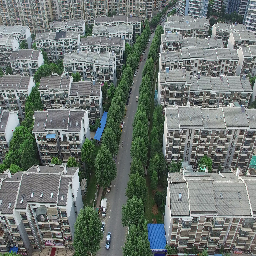

In [8]:
train_images[0]

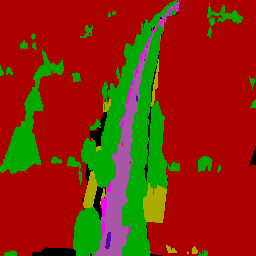

In [9]:
label_images[0]

In [10]:
# 假设 train_images[0] 和 label_images[0] 是可以转换为 ndarray 的对象  
train_array = np.asarray(train_images[0])  
label_array = np.asarray(label_images[0])  
  
# 确保数组的形状是 (height, width, channels)  
if train_array.ndim == 3 and train_array.shape[0] < train_array.shape[1]:  
    train_array = tf.image.transpose(train_array)  
if label_array.ndim == 3 and label_array.shape[0] < label_array.shape[1]:  
    label_array = tf.image.transpose(label_array)  
  
# 转换为图像对象  
train_image = tf.keras.preprocessing.image.array_to_img(train_array)  
label_image = tf.keras.preprocessing.image.array_to_img(label_array)  
  
# 更新列表中的元素  
train_images[0] = train_image  
label_images[0] = label_image

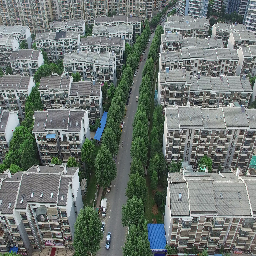

In [11]:
train_images[0]

In [12]:
# 我们将它们转换为 NumPy 数组  
train_image_array = np.array(train_images[0])  
label_image_array = np.array(label_images[0])  
  
# 将 NumPy 数组转换为 TensorFlow 张量  
train_image_tensor = tf.convert_to_tensor(train_image_array)  
label_image_tensor = tf.convert_to_tensor(label_image_array)  
  
# 创建一个会话  
with tf.Session() as sess:  
    # 应用随机亮度调整  
    brightness_adjusted_train_image = sess.run(tf.image.random_brightness(train_image_tensor, max_delta=0.2))  
    brightness_adjusted_label_image = sess.run(tf.image.random_brightness(label_image_tensor, max_delta=0.2))  
  
# 将调整后的 NumPy 数组转换回 PIL 图像  
brightness_adjusted_train_image_pil = Image.fromarray(brightness_adjusted_train_image)  
brightness_adjusted_label_image_pil = Image.fromarray(brightness_adjusted_label_image)  
  
# 将调整后的 PIL 图像替换原来的 PIL 图像  
train_images[0] = brightness_adjusted_train_image_pil  
label_images[0] = brightness_adjusted_label_image_pil

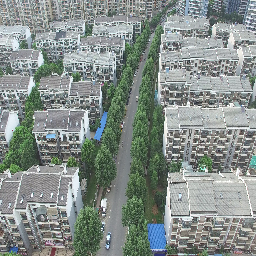

In [13]:
train_images[0]

In [14]:
#标签图片压缩
def flat_all_train_labels_path(train_label_path):
    
    train_labels = resize_all_train_images_path(train_label_path)
    
    for index in range(len(train_labels)):
        train_labels[index] = tf.keras.preprocessing.image.array_to_img(tf.image.resize(np.asarray(train_labels[index]), [ 1, 196608]))
    return train_labels

In [ ]:
train_labels = flat_all_train_labels_path(train_label_path)

In [ ]:
#将数据转换为tfrecord格式
'''从字符串/字节特征数据中提取字节特征数组'''
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

'''从单精度/双精度浮点型特征数据中提取单精度数组'''
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

'''从布尔值/计数/整型/无符号等类型特征数据转换为64位整型数组'''
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def write_record(train_images, train_labels, tfrecord_name):
    features = []
    # 读取原始数据，实现tfrecord数据格式转换
    for index in range(len(train_images)):
        buf_img = io.BytesIO()
        buf_label = io.BytesIO()

        train_images[index].save(buf_img, format='PNG')
        # temp = np.array(train_images[index])        
        image_string = buf_img.getvalue()
        train_labels[index].save(buf_label, format='PNG')
        
        # 测试集处理
        # temp = np.array(train_labels[index])
        
        label = buf_label.getvalue()

        #每一个样本均有两种特征：原始图片与标签。将其打包成单一字典
        feature = {
            'label': _bytes_feature(label),
            'image_raw': _bytes_feature(image_string),
        }
        
        features.append(feature)
    
    # 从单一字典中创建一个新‘样本’
    tf_examples = []
    for i in range(len(train_images)):
        tf_example = tf.train.Example(features=tf.train.Features(feature=features[i]))
        tf_examples.append(tf_example)
    # tf_example = tf.train.Example(features=tf.train.Features(feature=feature))
  
    # 将序列化文件写入tfrecord中.
    with tf.io.TFRecordWriter(tfrecord_name + ".tfrecord") as writer:
        for index in range(len(train_images)):
            writer.write(tf_examples[index].SerializeToString())

In [ ]:
write_record(train_images, label_images, tfrecord_name)

In [ ]:
#读取制作完成的dataset
def read_record(tfrecord_name):
    # 使用数据集API直接从TFRecord文件导入数据
    raw_image_dataset = tf.data.TFRecordDataset(tfrecord_name + ".tfrecord")

    # 创建一个描述特性的字典。字典的键值应该与写入函数中的键值相同。
    image_feature_description = {
        'label': tf.io.FixedLenFeature([], tf.string),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }

    #定义一个parse函数抓取单一样本作为字典。
    def _parse_image_function(example_proto):
        # 使用上述的字典解析原始tf.example部分.
        features = tf.io.parse_single_example(example_proto, image_feature_description)
        image = tf.io.decode_image(features['image_raw'], dtype=tf.uint8)
        print("TYPE: {}\tShape: {}".format(type(image), image.shape))
        #image.set_shape([3 * 256 * 256])
        image = tf.reshape(image, [256, 256, 3])
        
        label = tf.io.decode_image(features['label'], dtype=tf.uint8)
        print("TYPE: {}\tShape: {}".format(type(label), label.shape))
        #label.set_shape([ 1, 196608])
        label = tf.reshape(label,[ 1, 196608, 1]) # 这里的标签会发生变化

        return image,label
   
    dataset = raw_image_dataset.map(_parse_image_function)
    dataset = dataset.cache()
    dataset = dataset.batch(8)
        
    return dataset

In [ ]:
dataset = read_record(tfrecord_name)

In [ ]:
type(dataset)

In [ ]:
for x,y in dataset.take(1):
    print(type(x), type(y))
    x = x.numpy()
    y = y.numpy()
    print(type(x), type(y))
    print(len(x))
    print(x[0].shape)
    print(y[0].shape)
    img_neww = tf.keras.preprocessing.image.array_to_img(x[3])
    label_neww = tf.keras.preprocessing.image.array_to_img(y[0])